# Import Libreries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

from sklearn.metrics import  mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

epocas = 200

2025-01-19 17:14:12.967702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 17:14:12.990146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 17:14:12.994941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 17:14:13.019041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 17:14:14.322998: W tensorflow/compiler/tf2

# Load data

In [2]:
seis_full= np.load('data/data_decatur/processed/seismic_full.npy')
phi_full = np.load('data/data_decatur/processed/porosity_full.npy')

well_seismic_data = np.load('data/data_decatur/processed/well_seismic.npy')
well_porosity_data = np.load('data/data_decatur/processed/well_porosity.npy')

phi_full[phi_full<0] = 0

In [3]:
print(phi_full.shape, phi_full.min(), phi_full.max())

(143, 1211, 86) 0.0 0.25938374


In [26]:
depth_start = 4700
depth_end = 6380
depth_step = 20
depth_values = np.arange(depth_start, depth_end , depth_step)
num_ticks = 6 
depth_indices = np.linspace(0, len(depth_values) - 1, num_ticks, dtype=int)

inline_number = 83

# Custom Functions

## Normalization Functions

In [5]:
def scale_to_range(data, min_val=-1, max_val=1):
    """
    Scale data to a range (default [-1, 1]) using min-max normalization.
    
    Args:
        data: numpy array or list to be scaled
        min_val: minimum value of desired range (default -1)
        max_val: maximum value of desired range (default 1)
    
    Returns:
        scaled data in the specified range
    """
    data_min = np.min(data)
    data_max = np.max(data)
    
    # Prevent division by zero if all values are the same
    if data_max == data_min:
        return np.zeros_like(data)
    
    # First normalize to [0, 1]
    normalized = (data - data_min) / (data_max - data_min)
    
    # Then scale to [min_val, max_val]
    scaled = normalized * (max_val - min_val) + min_val
    
    return scaled

def unscale_from_range(scaled_data, original_min, original_max, min_val=-1, max_val=1):
    """
    Reverse the scaling operation to get back original values.
    
    Args:
        scaled_data: numpy array or list of scaled values
        original_min: minimum value from original dataset
        original_max: maximum value from original dataset
        min_val: minimum value of current range (default -1)
        max_val: maximum value of current range (default 1)
    
    Returns:
        data in original scale
    """
    # First normalize back to [0, 1]
    normalized = (scaled_data - min_val) / (max_val - min_val)
    
    # Then scale back to original range
    original = normalized * (original_max - original_min) + original_min
    
    return original


## R2 Metric

In [6]:
def r2_score(y_true, y_pred):
    """
    Calculate R² score using Keras backend operations.
    
    Parameters:
    -----------
    y_true : tensor
        Ground truth values
    y_pred : tensor
        Predicted values
        
    Returns:
    --------
    tensor
        R² score
    """
    # Convert inputs to tensors if they aren't already
    
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    
    ss_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return 1 - ss_res / (ss_tot + K.epsilon())  # Para evitar divisiones por cero

## Loss Function

In [7]:
class CustomSeismicLoss(tf.keras.losses.Loss):
    def __init__(self,
                 model,  # The neural network model
                 well_seismic_data,  # Seismic data at well locations S_w
                 well_porosity_data,  # Observed porosity at well locations φ_w
                 lambda_param=0.5,
                 name='custom_seismic_loss'):
        """
        Custom loss function for seismic to porosity mapping.
        
        Args:
            model (tf.keras.Model): Neural network model to predict porosity
            well_seismic_data (tf.Tensor): Seismic data at well locations S_w
            well_porosity_data (tf.Tensor): Observed porosity at well locations φ_w
            lambda_param (float): Regularization parameter
            name (str): Name of the loss function
        """
        super().__init__(name=name)
        self.model = model
        self.well_seismic_data = tf.convert_to_tensor(well_seismic_data, dtype=tf.float32)
        self.well_porosity_data = tf.convert_to_tensor(well_porosity_data, dtype=tf.float32)
        self.lambda_param = lambda_param
    
    def call(self, y_true, y_pred):
        """
        Compute the custom loss.
        
        Args:
            y_true (tf.Tensor): Actual porosity values
            y_pred (tf.Tensor): Predicted porosity values
        
        Returns:
            tf.Tensor: Computed loss value
        """
        # First term: L2 norm of prediction error for full dataset
        first_term = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # Second term: Predict porosity using well seismic data and compare with well porosity
        y_pred_well = self.model(self.well_seismic_data, training=False)
        second_term = (self.lambda_param / 2) * tf.reduce_mean(tf.square(self.well_porosity_data - y_pred_well ))
        
        # Total loss is the sum of both terms
        total_loss = first_term + second_term
        
        return total_loss

## LR Scheduler

In [8]:
class LearningRateSchedulerOnR2(tf.keras.callbacks.Callback):
    def __init__(self, patience=5, factor=0.5, min_lr=1e-6):
        super().__init__()
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.r2_scores = []
        self.consecutive_decrease_count = 0

    def on_epoch_end(self, epoch, logs=None):
        r2_score = logs.get('r2_score')
        if r2_score is None:
            print("R2 score is not logged; skipping learning rate adjustment.")
            return
        
        self.r2_scores.append(r2_score)
        
        if len(self.r2_scores) > 1:
            if r2_score < self.r2_scores[-2]:
                self.consecutive_decrease_count += 1
            else:
                self.consecutive_decrease_count = 0
            
        if self.consecutive_decrease_count >= self.patience:
            try:
                # Retrieve the old learning rate
                old_lr = float(self.model.optimizer.learning_rate.numpy())
                print(f"Old learning rate: {old_lr:.6f}")

                # Compute the new learning rate
                new_lr = max(old_lr * self.factor, self.min_lr)
                print(f"Computed new learning rate: {new_lr}, type: {type(new_lr)}")

                # Safely update the learning rate
                self.model.optimizer.learning_rate.assign(new_lr)
                print(f"Learning rate successfully updated to: {new_lr:.6f}")

                self.consecutive_decrease_count = 0  # Reset counter
            except Exception as e:
                print(f"Error during learning rate adjustment: {e}")
                print(f"Learning rate object: {self.model.optimizer.learning_rate}, type: {type(self.model.optimizer.learning_rate)}")
                raise


        
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1}: R2 score: {r2_score:.4f}, Learning rate: {current_lr:.6f}")



In [9]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        # Retrieve the current learning rate and store it
        current_lr = float(self.model.optimizer.learning_rate.numpy())
        self.learning_rates.append(current_lr)
        print(f"Learning rate for epoch {epoch+1}: {current_lr:.6f}")


# Data Wrangling

In [10]:
X = seis_full.reshape(-1,86,1,1)
Y = phi_full.reshape(-1,86,1,1)

In [11]:
X_norm = scale_to_range(X)
Y_norm = scale_to_range(Y)

well_seismic_data = scale_to_range(well_seismic_data)
well_porosity_data = scale_to_range(well_porosity_data)

In [12]:
X_norm.shape, X_norm.min(), X_norm.max()

((173173, 86, 1, 1), -1.0, 1.0)

In [13]:
Y_norm.shape, Y_norm.min(), Y_norm.max()

((173173, 86, 1, 1), -1.0, 1.0)

# NN Model

## Architecture

In [14]:
def simplified_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    # Bloque 1
    x1 = tf.keras.layers.Conv2D(6, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(inputs)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)

    
    # Bloque 2
    x2 = tf.keras.layers.Conv2D(12, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x1)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    
    # Output shape: (86, 1, 12)
    drop = tf.keras.layers.Dropout(0.5)(x2)  # 50% of neurons are randomly dropped during training
    
    flat_bottle_neck = tf.keras.layers.Flatten()(drop)
    dense_bottle_neck = tf.keras.layers.Dense(1032, activation='leaky_relu')(flat_bottle_neck)
    reshape_bottleneck = tf.keras.layers.Reshape((86, 1, 12))(dense_bottle_neck)
    
    # Bloque 3
    x3 = tf.keras.layers.Conv2D(24, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(reshape_bottleneck)
    x3 = tf.keras.layers.LeakyReLU()(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)

    
    # Bloque 4
    x4 = tf.keras.layers.Conv2D(30, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x3)
    x4 = tf.keras.layers.LeakyReLU()(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)

    
    x4 = tf.keras.layers.Conv2D(1, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x4)
    x4 = tf.keras.layers.LeakyReLU()(x4)
    outputs = tf.keras.layers.BatchNormalization()(x4)

    
    model = tf.keras.Model(inputs, outputs)
    return model

# Definir las dimensiones de entrada
input_shape = (86, 1, 1)
model_own = simplified_cnn(input_shape)
print(model_own.summary())

I0000 00:00:1737324856.919921   92940 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737324856.977423   92940 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737324856.977665   92940 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737324856.982466   92940 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737324856.982641   92940 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 86, 1, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 86, 1, 6)       │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 86, 1, 6)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 86, 1, 6)       │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 86, 1, 12)      │           372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 86, 1, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 86, 1, 12)      │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86, 1, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1032)           │     1,066,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 86, 1, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 86, 1, 24)      │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 86, 1, 24)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 86, 1, 24)      │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 86, 1, 30)      │         3,630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 86, 1, 30)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 86, 1, 30)      │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 86, 1, 1)       │           151 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 86, 1, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 86, 1, 1)       │             4 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,001 (4.09 MB)

 Trainable params: 1,071,855 (4.09 MB)

 Non-trainable params: 146 (584.00 B)

None


## Compile model

In [15]:
# Shuffle and Split Full Dataset into Train/Test
test_size = 0.2  # 20% for the test set
pos = np.random.permutation(Y_norm.shape[0])
X_shuffled, Y_shuffled = X_norm[pos], Y_norm[pos]

X_train, X_test, Y_train, Y_test = train_test_split(X_shuffled, Y_shuffled, test_size=test_size, random_state=42)

# K-Fold Cross-Validation on the Training Data
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cv_scores = []
histories = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold+1}/{k}")
    
    # Split training data into K-Fold subsets
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]
    
    # Create a new model instance for this fold
    model_own = simplified_cnn(input_shape)
    
    # Compile the model
    custom_loss = CustomSeismicLoss(
        model_own,
        well_seismic_data, 
        well_porosity_data, 
        lambda_param=0.1
    )

    initial_lr = 0.001
    model_own.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), 
                      loss=custom_loss, 
                      metrics=['mae', r2_score])  
    
    # Define callbacks for this fold
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'models/fold_{fold+1}_training_paul.weights.h5',
        save_weights_only=True,
        verbose=1
    )

    lr_scheduler = LearningRateSchedulerOnR2(patience=1, factor=0.8, min_lr=1e-6)
    
    callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_r2_score', 
                                                      patience=10, 
                                                      mode='max',
                                                      min_delta=0.1)
    lr_logger = LearningRateLogger()

    # Train the model
    history = model_own.fit(
        X_train_fold, Y_train_fold,
        validation_data=(X_val_fold, Y_val_fold),
        epochs=epocas, 
        batch_size=512, 
        shuffle=True,
        callbacks=[checkpoint, lr_logger, lr_scheduler]
    )

    # Evaluate the model on the validation set
    val_predictions = model_own.predict(X_val_fold)
    fold_r2 = r2_score(Y_val_fold, val_predictions)
    cv_scores.append(fold_r2)
    histories.append(history)
    print(f"R2 Score for Fold {fold+1}: {fold_r2:.4f}")

# Evaluate on the Test Set (Unseen Data)
test_predictions = model_own.predict(X_test)
test_r2 = r2_score(Y_test, test_predictions)

# Aggregate Cross-Validation Results
print("\nCross-Validation Results:")
print(f"R2 Scores: {cv_scores}")
print(f"Mean R2 Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")
print(f"\nR2 Score on Test Set: {test_r2:.4f}")



Fold 1/5
Epoch 1/200


I0000 00:00:1737324862.941029   93003 service.cc:146] XLA service 0x7fdf68018ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737324862.941148   93003 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-01-19 17:14:23.057116: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-19 17:14:23.667975: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-01-19 17:14:29.187297: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 10/217 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 5.3923 - mae: 0.6367 - r2_score: -5.4968

I0000 00:00:1737324874.276977   93003 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 3.0667 - mae: 0.5072 - r2_score: -2.4531
Epoch 1: saving model to models/fold_1_training_paul.weights.h5
Learning rate for epoch 1: 0.001000
Epoch 1: R2 score: -1.6721, Learning rate: 0.001000
217/217 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - loss: 3.0605 - mae: 0.5070 - r2_score: -2.4495 - val_loss: 0.4720 - val_mae: 0.2138 - val_r2_score: 0.3122
Epoch 2/200
216/217 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4187 - mae: 0.3594 - r2_score: -0.4202
Epoch 2: saving model to models/fold_1_training_paul.weights.h5
Learning rate for epoch 2: 0.001000
Epoch 2: R2 score: -0.1894, Learning rate: 0.001000
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.4177 - mae: 0.3591 - r2_score: -0.4180 - val_loss: 0.1295 - val_mae: 0.1486 - val_r2_score: 0.6735
Epoch 3/200
215/217 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1247 - mae: 0.1932 - r2_score: 0.5071
Epoch 3: saving model to models/fold_1_training_paul.weights.h5
Learning rate for epoch 3: 0.0010

In [16]:
cv_scores

[<tf.Tensor: shape=(), dtype=float32, numpy=0.9120323>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.98011345>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9780739>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.97987646>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9811602>]

## Metrics

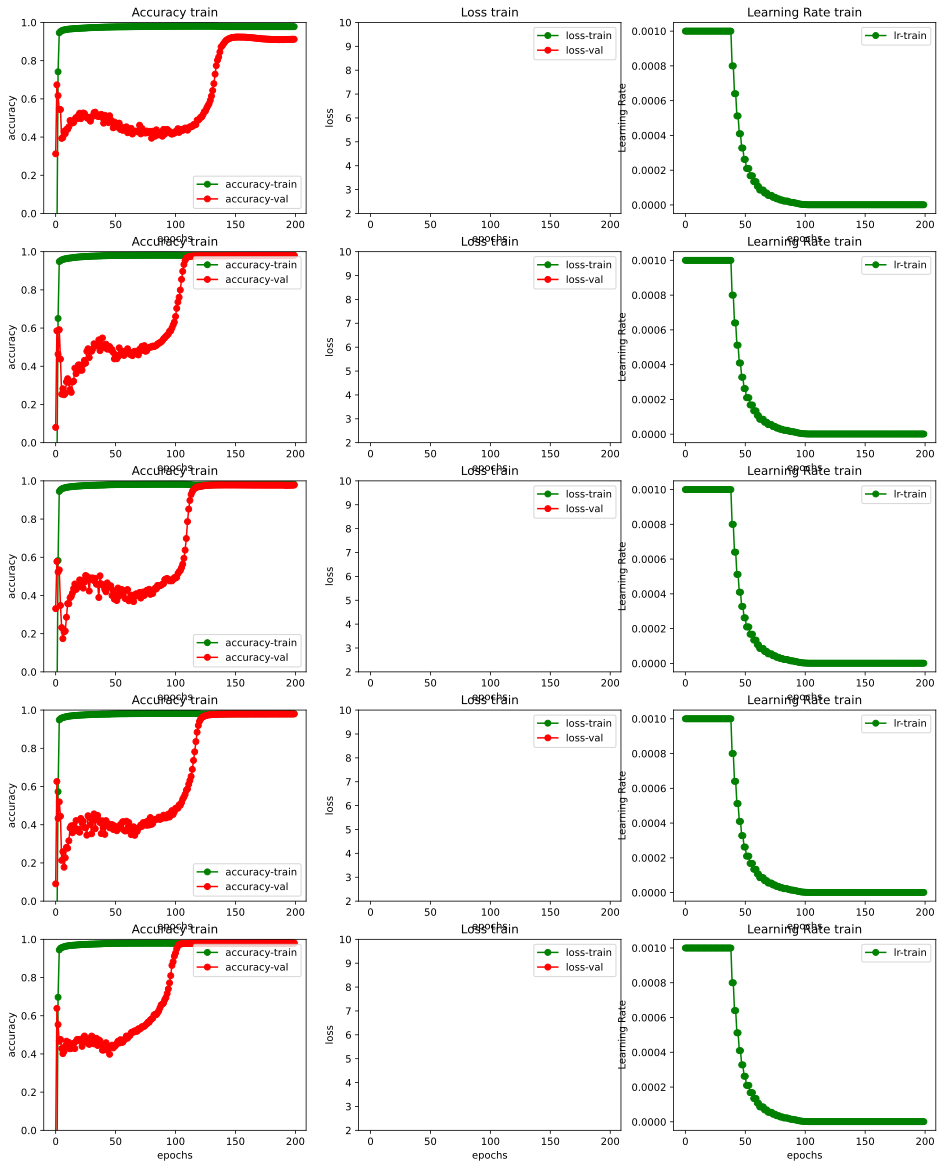

In [17]:
epochs = [i for i in range(len(history.history['r2_score']))]

fig, ax = plt.subplots(5,3)
fig.set_size_inches(16,20)
counter = 0
for history in histories:
    

    train_acc = history.history['r2_score']
    train_loss = history.history['loss']
    val_acc = history.history['val_r2_score']
    val_loss = history.history['val_loss']
    #train_lr = history_own.history['learning_rate']

    ax[counter,0].plot(epochs, train_acc, 'go-', label='accuracy-train')
    ax[counter,0].plot(epochs, val_acc, 'ro-', label='accuracy-val')
    ax[counter,0].set_title('Accuracy train')
    ax[counter,0].legend()
    ax[counter,0].set_xlabel('epochs')
    ax[counter,0].set_ylabel('accuracy')
    ax[counter,0].set_ylim(0,1)

    ax[counter,1].plot(epochs, train_loss, 'go-', label='loss-train')
    ax[counter,1].plot(epochs, val_loss, 'ro-', label='loss-val')
    ax[counter,1].set_title('Loss train')
    ax[counter,1].legend()
    ax[counter,1].set_xlabel('epochs')
    ax[counter,1].set_ylabel('loss')
    ax[counter,1].set_ylim(2,10)


    ax[counter, 2].plot(epochs, lr_logger.learning_rates, 'go-', label='lr-train')
    ax[counter, 2].set_title('Learning Rate train')
    ax[counter, 2].legend()
    ax[counter, 2].set_xlabel('epochs')
    ax[counter,2].set_ylabel('Learning Rate')
    counter += 1

In [18]:
history.history.keys()

dict_keys(['loss', 'mae', 'r2_score', 'val_loss', 'val_mae', 'val_r2_score'])

In [19]:
loss, mae, accuracy = model_own.evaluate(X_test, Y_test)

1083/1083 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0042 - mae: 0.0338 - r2_score: 0.9811


In [20]:
y_pred_cnn_own = model_own.predict(X_test)

1083/1083 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [21]:
Y_test_own_cnn_norm = np.squeeze(Y_test)
y_pred_cnn_own = np.squeeze(y_pred_cnn_own)

In [22]:
Y_test_own_cnn_norm.shape, y_pred_cnn_own.shape

((34635, 86), (34635, 86))

In [23]:
rmse_own_cnn = np.sqrt(mean_squared_error(Y_test_own_cnn_norm, y_pred_cnn_own))
MAE_own_cnn = mean_absolute_error(Y_test_own_cnn_norm, y_pred_cnn_own)
r2_own_cnn = r2_score(Y_test_own_cnn_norm, y_pred_cnn_own)

print("RMSE : % f" %(rmse_own_cnn))
print("MAE : % f" %(MAE_own_cnn))
print("R2 : % f" %(r2_own_cnn))

RMSE :  0.049188
MAE :  0.033748
R2 :  0.981225
